In [41]:
from dotenv import load_dotenv
from langchain.tools import tool
from typing import Dict, Any
from tavily import TavilyClient
from langchain_community.utilities import SQLDatabase
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage
from langgraph.prebuilt import  ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import List, Annotated
from typing_extensions import TypedDict
from langgraph.runtime import Runtime
from langchain_openai import ChatOpenAI

load_dotenv()

True

In [42]:
tavily_client = TavilyClient()

db = SQLDatabase.from_uri("sqlite:///resources/Chinook.db")

In [43]:
@tool
def web_search(query: str) -> Dict[str, Any]:

    """Search the web for information"""

    return tavily_client.search(query)

@tool
def sql_query(query: str) -> str:

    """Obtain information from the database using SQL queries"""

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

In [44]:
class UserRole(TypedDict):
    user_role: str

class ChatAgent(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

In [ ]:
def chatNode(state: ChatAgent, runtime: Runtime[UserRole]) -> dict:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    user_role = runtime.context.get("user_role", "internel")
    # Dynamically select tools based on user_role
    if user_role == "internel":
        tools = [web_search, sql_query]
    else:
        tools = [web_search]

    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

In [46]:
graph = StateGraph(ChatAgent, context_schema=UserRole)

graph.add_node("chat", chatNode)
graph.add_node("tools", ToolNode([web_search, sql_query]))

graph.add_edge(START, "chat")
graph.add_conditional_edges("chat", tools_condition)
graph.add_edge("tools", "chat")

workflow = graph.compile()

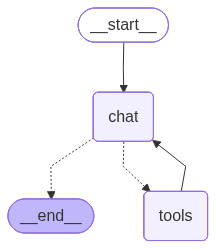

In [47]:
workflow

In [48]:
from langchain.messages import HumanMessage

response = workflow.invoke(
    {
        "messages": [HumanMessage(content="How many artists are in the database?")],
    },
    context={"user_role": "internel"}
)

print(response["messages"][-1].content)
# Reponse: There are 275 artists in the database.

There are 275 artists in the database.


In [50]:
from langchain.messages import HumanMessage

response = workflow.invoke(
    {
        "messages": [HumanMessage(content="How many artists are in the database?")]
    },
    context={"user_role": "external"}
)

print(response["messages"][-1].content)

The search results indicate that there is a database of 16,000 artists used to train the Midjourney AI. Additionally, there is a dataset that consists of over 1.4 million musical artists present in the MusicBrainz database. 

If you are looking for a specific database, please provide more details so I can assist you better!
